# Electric Motor Temperature Prediction
Given data about electric motors, let's try to predict the rotor temperature of a given motor.

We will use a linear regression model to make our predictions.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
data = pd.read_csv('measures_v2.csv')


In [5]:
data.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


In [28]:
data.columns

Index(['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
       'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque',
       'profile_id'],
      dtype='object')

In [6]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


In [7]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop profile_id column
    df = df.drop('profile_id', axis=1)
    
    # Split df into X and y
    y = df['pm'].copy()
    X = df.drop('pm', axis=1).copy()
    
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X, y

In [8]:
X, y = preprocess_inputs(data)


In [9]:
eda_df = pd.concat([X, y], axis=1).copy()


In [10]:
eda_df.describe()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,stator_yoke,ambient,torque,pm
count,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06
mean,-1.417626e-15,-1.479036e-14,-1.623962e-14,-6.424697e-15,2.581159e-14,1.802474e-15,1.448287e-15,-5.726945e-16,-6.683599e-14,-2.172880e-13,4.327005e-13,5.850678e+01
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.900150e+01
min,-1.801316e+00,-1.175346e+00,-1.665627e+00,-1.686374e+00,-1.688055e+00,-1.332301e+00,-3.223109e+00,-3.588988e+00,-1.506242e+00,-8.179116e+00,-3.598497e+00,2.085696e+01
25%,-9.555356e-01,-8.047253e-01,-8.215244e-01,-8.488737e-01,-8.043913e-01,-1.013609e+00,-7.190350e-01,-3.939704e-01,-8.102463e-01,-7.154374e-01,-4.050452e-01,4.315158e+01
50%,-1.209064e-01,-4.282472e-01,-4.299018e-02,2.806072e-01,-3.669520e-02,-1.086778e-01,2.714027e-01,-2.347401e-01,-1.281805e-01,1.202738e-01,-2.624682e-01,6.026629e+01
75%,8.094359e-01,6.255120e-01,7.602662e-01,4.216716e-01,8.150887e-01,8.380866e-01,1.012381e+00,6.855945e-01,6.639420e-01,8.560482e-01,7.842169e-01,7.200837e+01
max,1.782935e+00,3.000463e+00,2.616490e+00,2.482149e+00,2.399238e+00,2.042271e+00,1.059068e+00,2.867105e+00,2.649193e+00,3.186775e+00,2.980456e+00,1.136066e+02


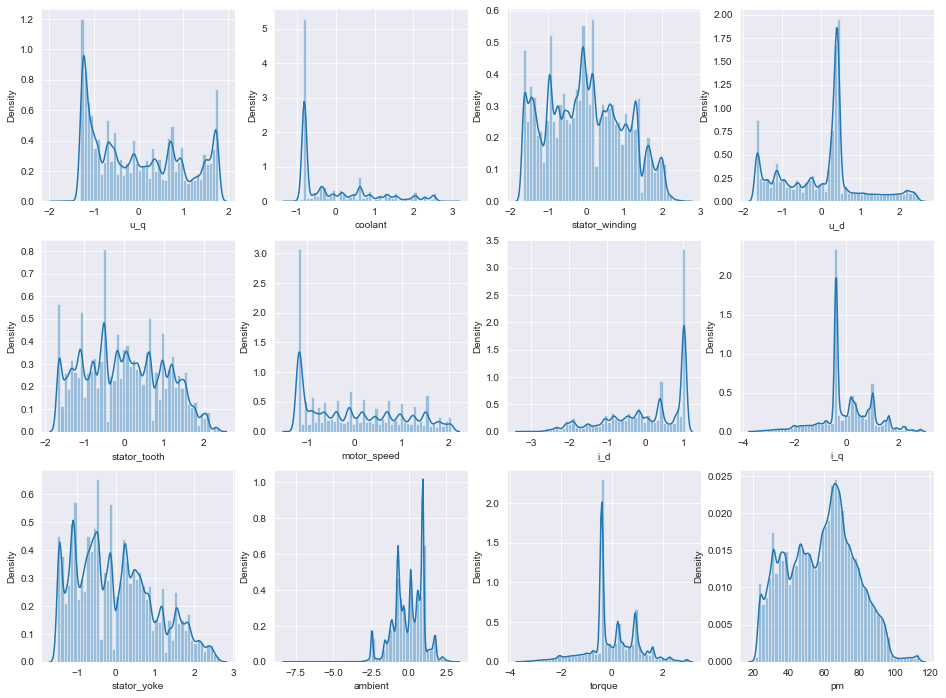

In [11]:
plt.figure(figsize=(16, 12))
for i in range(len(eda_df.columns)):
    plt.subplot(3, 4, i + 1)
    sns.distplot(eda_df[eda_df.columns[i]])
plt.show()

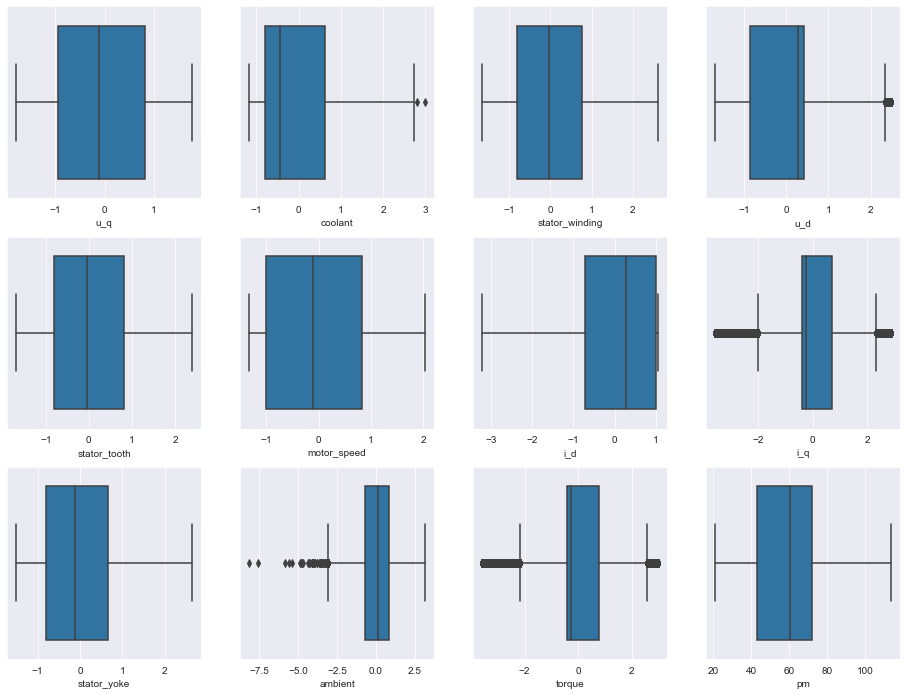

In [12]:
plt.figure(figsize=(16, 12))
for i in range(len(eda_df.columns)):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(eda_df[eda_df.columns[i]])
plt.show()

<Figure size 1152x1152 with 0 Axes>

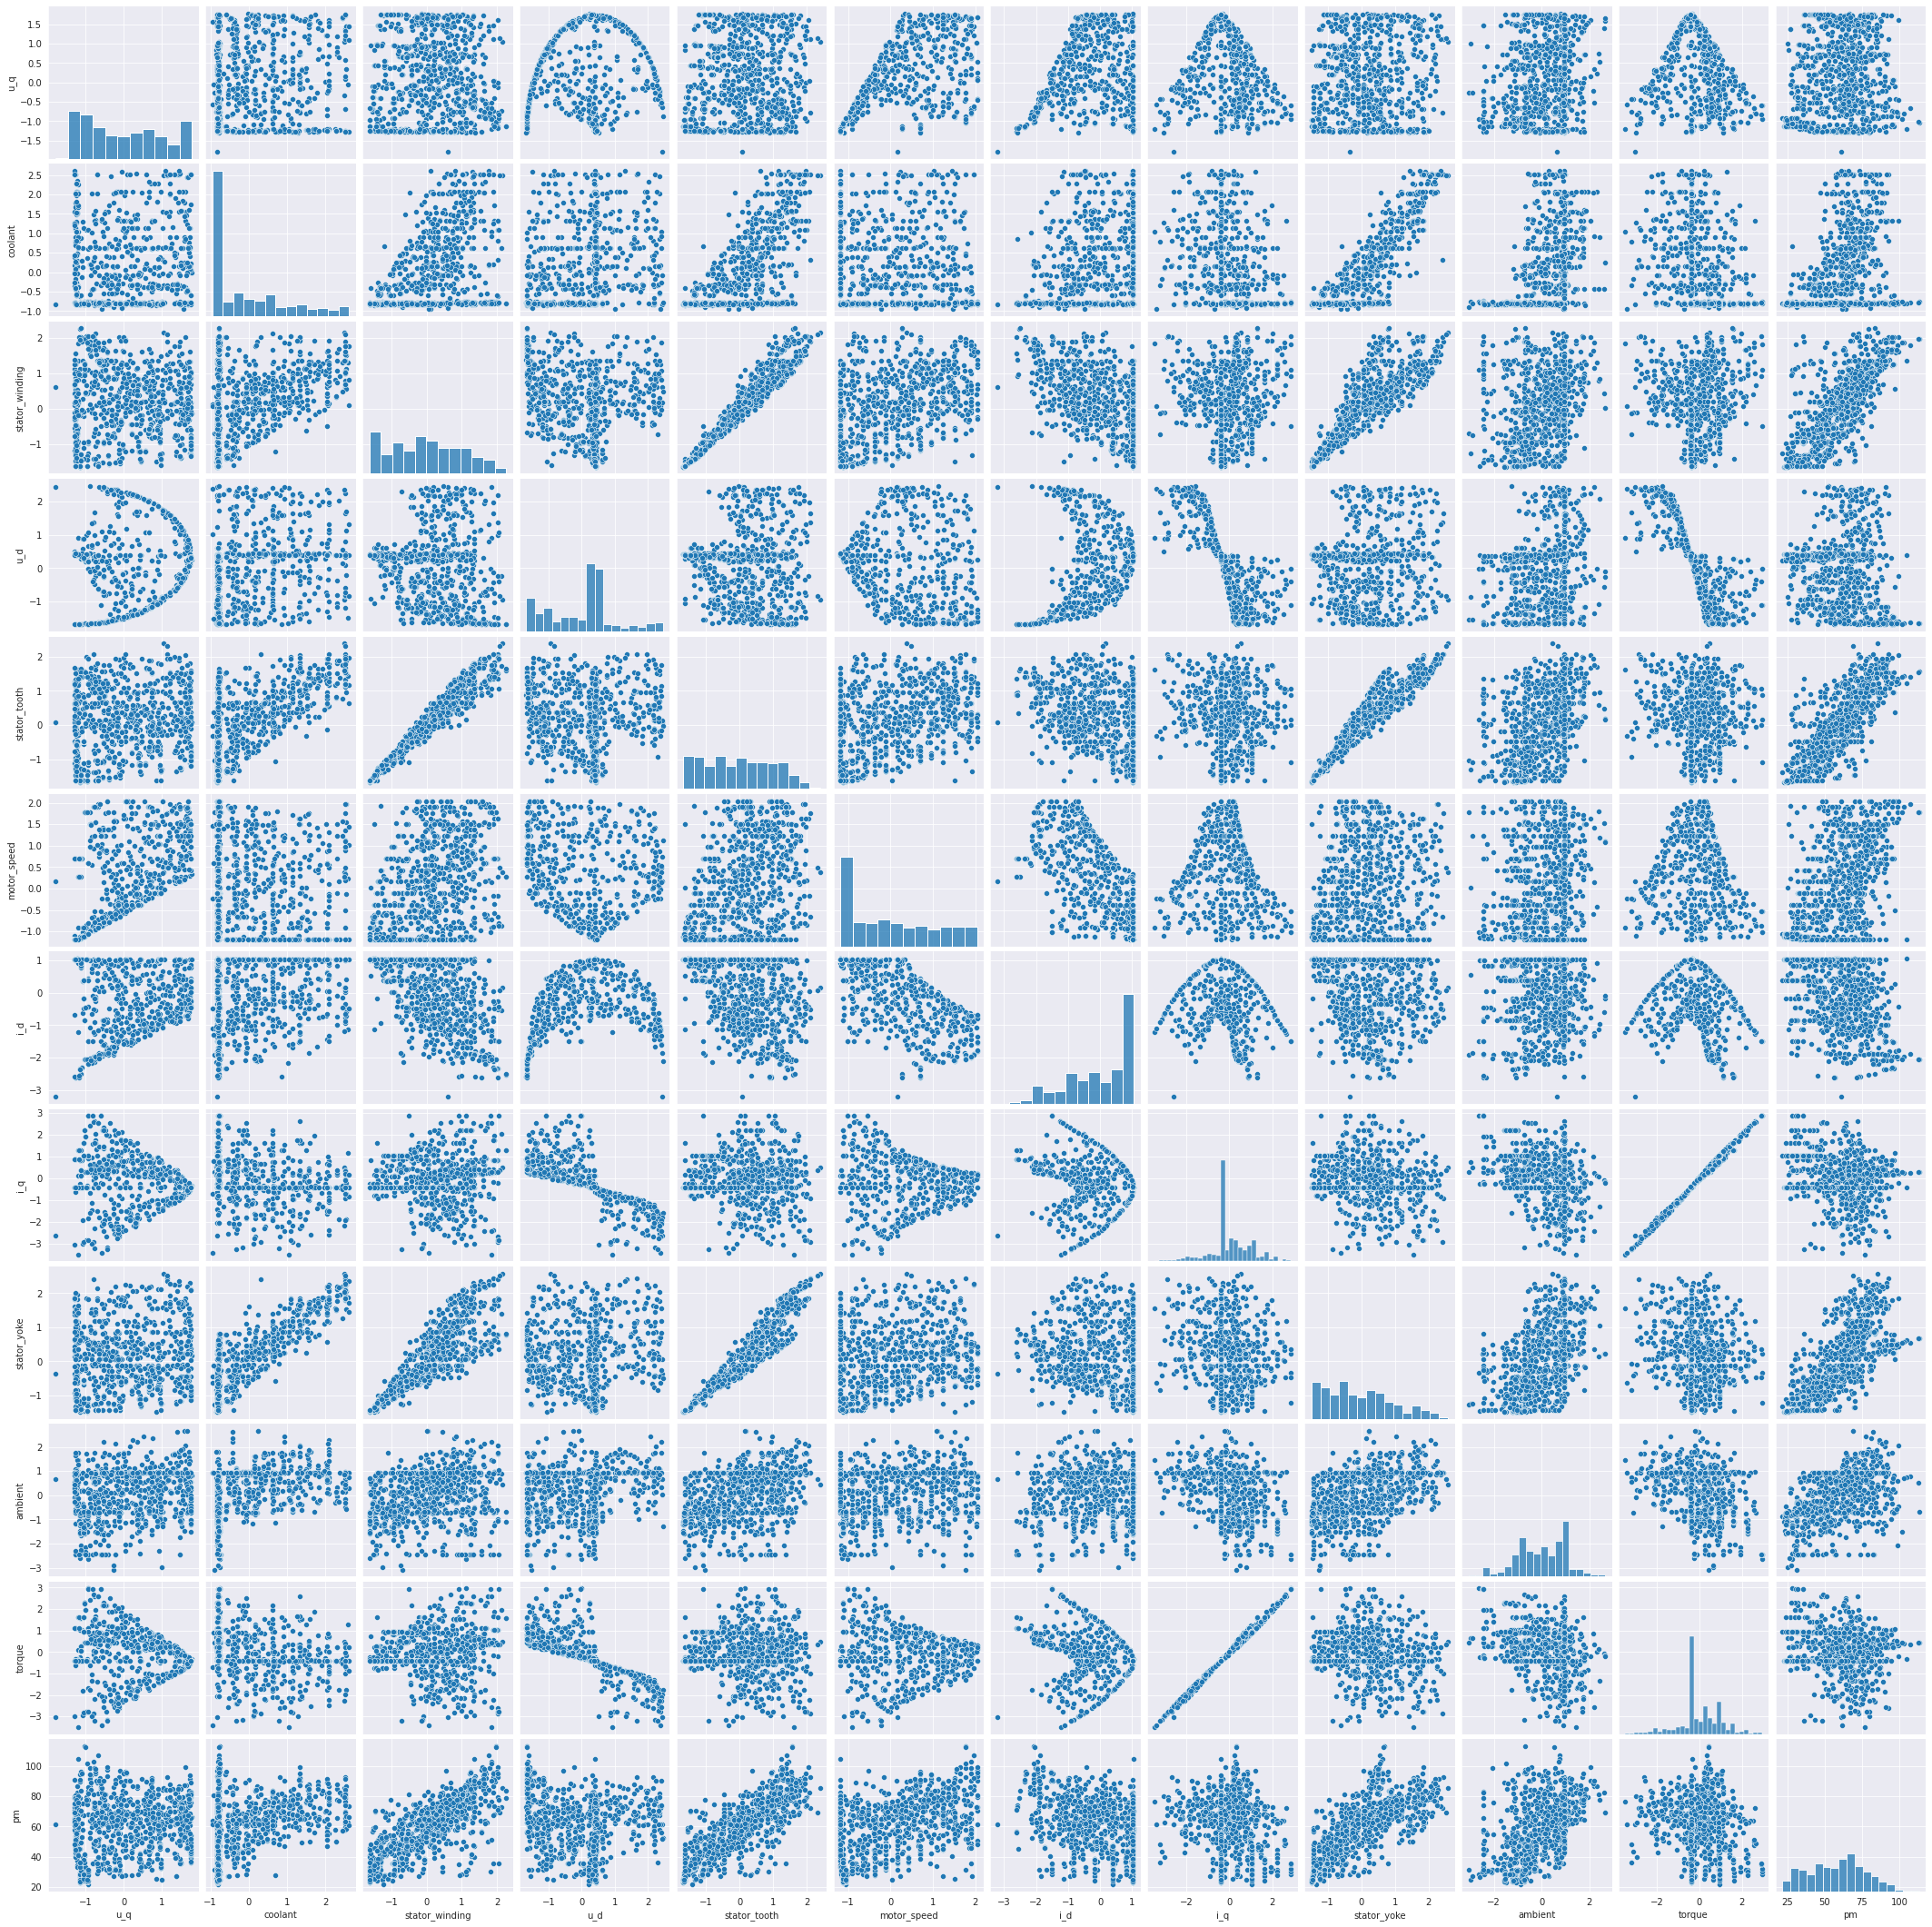

In [14]:
plt.figure(figsize=(16, 16))
sns.pairplot(eda_df.sample(1000))
plt.show()

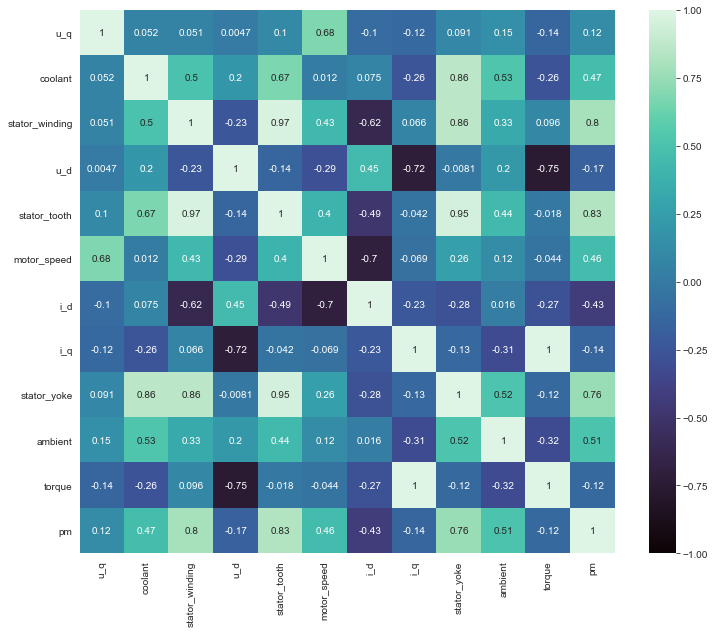

In [13]:
corr = eda_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.show()

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

In [15]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [16]:
print("Model R^2 Score: {:.4f}".format(model.score(X_test, y_test)))

Model R^2 Score: 0.8553


In [17]:
predictions=model.predict(X_test)

In [41]:
import numpy
features_name = ['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
                 'motor_speed', 'i_d', 'i_q', 'stator_yoke', 'ambient', 'torque']
values = [[-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,18.316547,19.850691,0.187101]]
arr = numpy.array(values)
df = pd.DataFrame(values, columns=features_name)
output = model.predict(df)
output

array([267.99415427])

In [21]:
import pickle
# open a file, where you ant to store the data
file = open('model.pkl', 'wb')

# dump information to that file
pickle.dump(model, file)